<a href="https://colab.research.google.com/github/rajni-arora/Machine-Learning-2024/blob/main/Spam_Ham_Detection_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spam Ham Detection using BERT**

#### Version of both Tensorflow and tensorflow_text should be same

In [ ]:
!pip install tensorflow_text==2.15.*

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub


from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
import tensorflow_text as text

In [ ]:
# Read Data
df = pd.read_csv("/content/dataset/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [ ]:
# Get all spams labels
spam_df = df[df['Category']=='spam']
spam_df.shape

(747, 2)

In [ ]:
# Get all hams labels
ham_df = df[df['Category']=='ham']
ham_df.shape

(4825, 2)

In [ ]:
# Get random sample from ham data in size of spam data
ham_df_downsampled = ham_df.sample(spam_df.shape[0])
ham_df_downsampled.shape

(747, 2)

In [ ]:
# Create balanced data that contains the same size of two categories
balanced_df = pd.concat([ham_df_downsampled, spam_df])
balanced_df.shape

(1494, 2)

In [ ]:
# New balanced data distribution
balanced_df['Category'].value_counts()

Category
ham     747
spam    747
Name: count, dtype: int64

In [ ]:
balanced_df.head()

,Category,Message
475,ham,Nice line said by a broken heart- Plz don't cu...
1601,ham,K.then any other special?
228,ham,Hey company elama po mudyadhu.
3950,ham,HMM yeah if your not too grooved out! And im l...
597,ham,Gud mrng dear have a nice day


In [ ]:
# Create a new column that contains encoded values of Category ['ham':0, 'spam':1]
balanced_df['spam']= balanced_df['Category'].apply(lambda x: 1 if x=='spam' else 0)
balanced_df.sample(5)

,Category,Message,spam
3357,ham,Ok not a problem will get them a taxi. C ing ...,0
5482,spam,URGENT We are trying to contact you Last weeke...,1
1544,spam,Hello from Orange. For 1 month's free access t...,1
3261,ham,I'm always looking for an excuse to be in the ...,0
1573,spam,Ur cash-balance is currently 500 pounds - to m...,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['Message'], balanced_df['spam'], stratify=balanced_df['spam'])

In [ ]:
import tensorflow_hub as hub

In [ ]:
# Preprocessing model
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
# BERT model
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# This function apply bert preprocessing on sentences
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

print(cosine_similarity([e[0]],[e[4]]))
print(cosine_similarity([e[2]],[e[3]]))
print(cosine_similarity([e[4]],[e[5]]))

[[0.8933631]]
[[0.84945345]]
[[0.9164156]]


In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
                                                                  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                                                  tf.keras.metrics.Precision(name='precision'),
                                                                  tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Get summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 13s 365ms/step - loss: 0.3675 - accuracy: 0.8795 - precision: 0.8696 - recall: 0.8929
Epoch 2/10
35/35 [==============================] - 12s 348ms/step - loss: 0.3423 - accuracy: 0.8804 - precision: 0.8635 - recall: 0.9036
Epoch 3/10
35/35 [==============================] - 12s 355ms/step - loss: 0.3349 - accuracy: 0.8830 - precision: 0.8757 - recall: 0.8929
Epoch 4/10
35/35 [==============================] - 12s 348ms/step - loss: 0.3164 - accuracy: 0.9000 - precision: 0.8916 - recall: 0.9107
Epoch 5/10
35/35 [==============================] - 12s 346ms/step - loss: 0.3011 - accuracy: 0.9027 - precision: 0.8868 - recall: 0.9232
Epoch 6/10
35/35 [==============================] - 12s 336ms/step - loss: 0.2940 - accuracy: 0.9062 - precision: 0.9027 - recall: 0.9107
Epoch 7/10
35/35 [==============================] - 12s 333ms/step - loss: 0.2873 - accuracy: 0.9062 - precision: 0.8970 - recall: 0.9179
Epoch 8/10
35/35 [================

In [ ]:
# Evaluate model
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 379ms/step - loss: 0.2487 - accuracy: 0.9198 - precision: 0.9337 - recall: 0.9037


[0.24868515133857727,
 0.9197860956192017,
 0.9337016344070435,
 0.903743326663971]

In [ ]:
# Get prediction
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 6s 394ms/step


In [ ]:
# Get label of each predicted value according to a threshold
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,

In [ ]:
cm = confusion_matrix(y_test, y_predicted)
cm

array([[175,  12],
       [ 18, 169]])

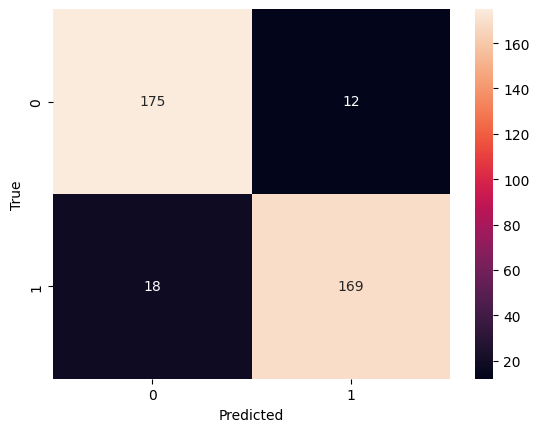

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       187
           1       0.93      0.90      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [ ]:
emails = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
preds = model.predict(emails)

1/1 [==============================] - 1s 856ms/step


In [ ]:
labels = ['Not Spam', 'Spam']
for i in range(len(preds)):
    print(f'{emails[i]} ==> {labels[int(np.round(preds[i]))]}')

Enter a chance to win $5000, hurry up, offer valid until march 31, 2021 ==> Spam
You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99 ==> Spam
it to 80488. Your 500 free text messages are valid until 31 December 2005. ==> Spam
Hey Sam, Are you coming for a cricket game tomorrow ==> Not Spam
Why don't you wait 'til at least wednesday to see if you get your . ==> Not Spam


<ipython-input-34-5db0ee669611>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'{emails[i]} ==> {labels[int(np.round(preds[i]))]}')
